# Investigate which features are most important for predictions

In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as PipeIMBL

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import json
import vae_utils
import torch
# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import AtlasAnalysisFunctions as AAF
import utils_ML as uml

import shap
shap.initjs()
plt.style.use('seaborn-dark')

In [2]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
data_quant = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
data_quant.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [3]:
with open("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/selected_features.txt", "r") as f:
    features = f.readlines()
    features = [x.strip() for x in features]
data_quant = data_quant.loc[:, features]

In [4]:
dataset = data_quant.reset_index(drop=True).rename(columns={data_quant.columns[x]:x for x in range(len(data_quant.columns))})

In [5]:
#imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
imputer = uml.LowestValueImputerGaussian()
dataset = imputer.fit_transform(dataset,targets)
dataset = MinMaxScaler().fit_transform(dataset)

In [6]:
quant_imputed = pd.DataFrame(dataset, columns = data_quant.columns)

In [7]:
model_smote_1 = LogisticRegression(max_iter=10000, C=50, solver="liblinear", penalty="l2")
model_smote_2 = SVC(C=15, kernel="rbf", probability=True)
model_smote_3 = RandomForestClassifier(n_estimators = 150, criterion="entropy", max_depth = 10)

In [8]:
model_vae_1 = LogisticRegression(max_iter=10000, C=50, solver="liblinear", penalty="l2")
model_vae_2 = SVC(C=15, kernel="rbf", probability=True)
model_vae_3 = RandomForestClassifier(n_estimators = 150, criterion="entropy", max_depth = 10)

In [9]:
smote = SMOTE()
vae = vae_utils.VariationalAutoencoder(6, 161, 50)
vae.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model_filtered"))

<All keys matched successfully>

In [10]:
no_label_quant_imputed = quant_imputed.reset_index(drop=True).rename(columns={quant_imputed.columns[x]:x for x in range(len(quant_imputed.columns))})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(no_label_quant_imputed, targets,
                                                    stratify=targets, 
                                                    test_size=0.15,
                                                    random_state=42)

In [13]:
smote_oversampled, y_oversampled = SMOTE().fit_resample(X_train, y_train)
vae_oversampled, y_vae = vae_utils.resampleVAE(vae, X_train.to_numpy().astype("float32"), list(y_train), 10)
vae_oversampled = pd.DataFrame(vae_oversampled, columns = quant_imputed.columns)

model_smote_2.fit(smote_oversampled, y_oversampled)
model_vae_2.fit(vae_oversampled, y_vae)

Y_pred_svc_smote = model_smote_2.predict(X_test)
Y_pred_svc_vae = model_vae_2.predict(X_test)

Minority: 80; Goal: 850
Minority: 160; Goal: 850
Minority: 240; Goal: 850
Minority: 320; Goal: 850
Minority: 400; Goal: 850
Minority: 480; Goal: 850
Minority: 560; Goal: 850
Minority: 640; Goal: 850
Minority: 720; Goal: 850
Minority: 800; Goal: 850
Reconstructing 12310 datapoints...
Reconstructed 500/12310
Reconstructed 1000/12310
Reconstructed 1500/12310
Reconstructed 2000/12310
Reconstructed 2500/12310
Reconstructed 3000/12310
Reconstructed 3500/12310
Reconstructed 4000/12310
Reconstructed 4500/12310
Reconstructed 5000/12310
Reconstructed 5500/12310
Reconstructed 6000/12310
Reconstructed 6500/12310
Reconstructed 7000/12310
Reconstructed 7500/12310
Reconstructed 8000/12310
Reconstructed 8500/12310
Reconstructed 9000/12310
Reconstructed 9500/12310
Reconstructed 10000/12310
Reconstructed 10500/12310
Reconstructed 11000/12310
Reconstructed 11500/12310
Reconstructed 12000/12310
Resampled from VAE


X does not have valid feature names, but SVC was fitted with feature names


Text(252.5, 0.5, 'True label')

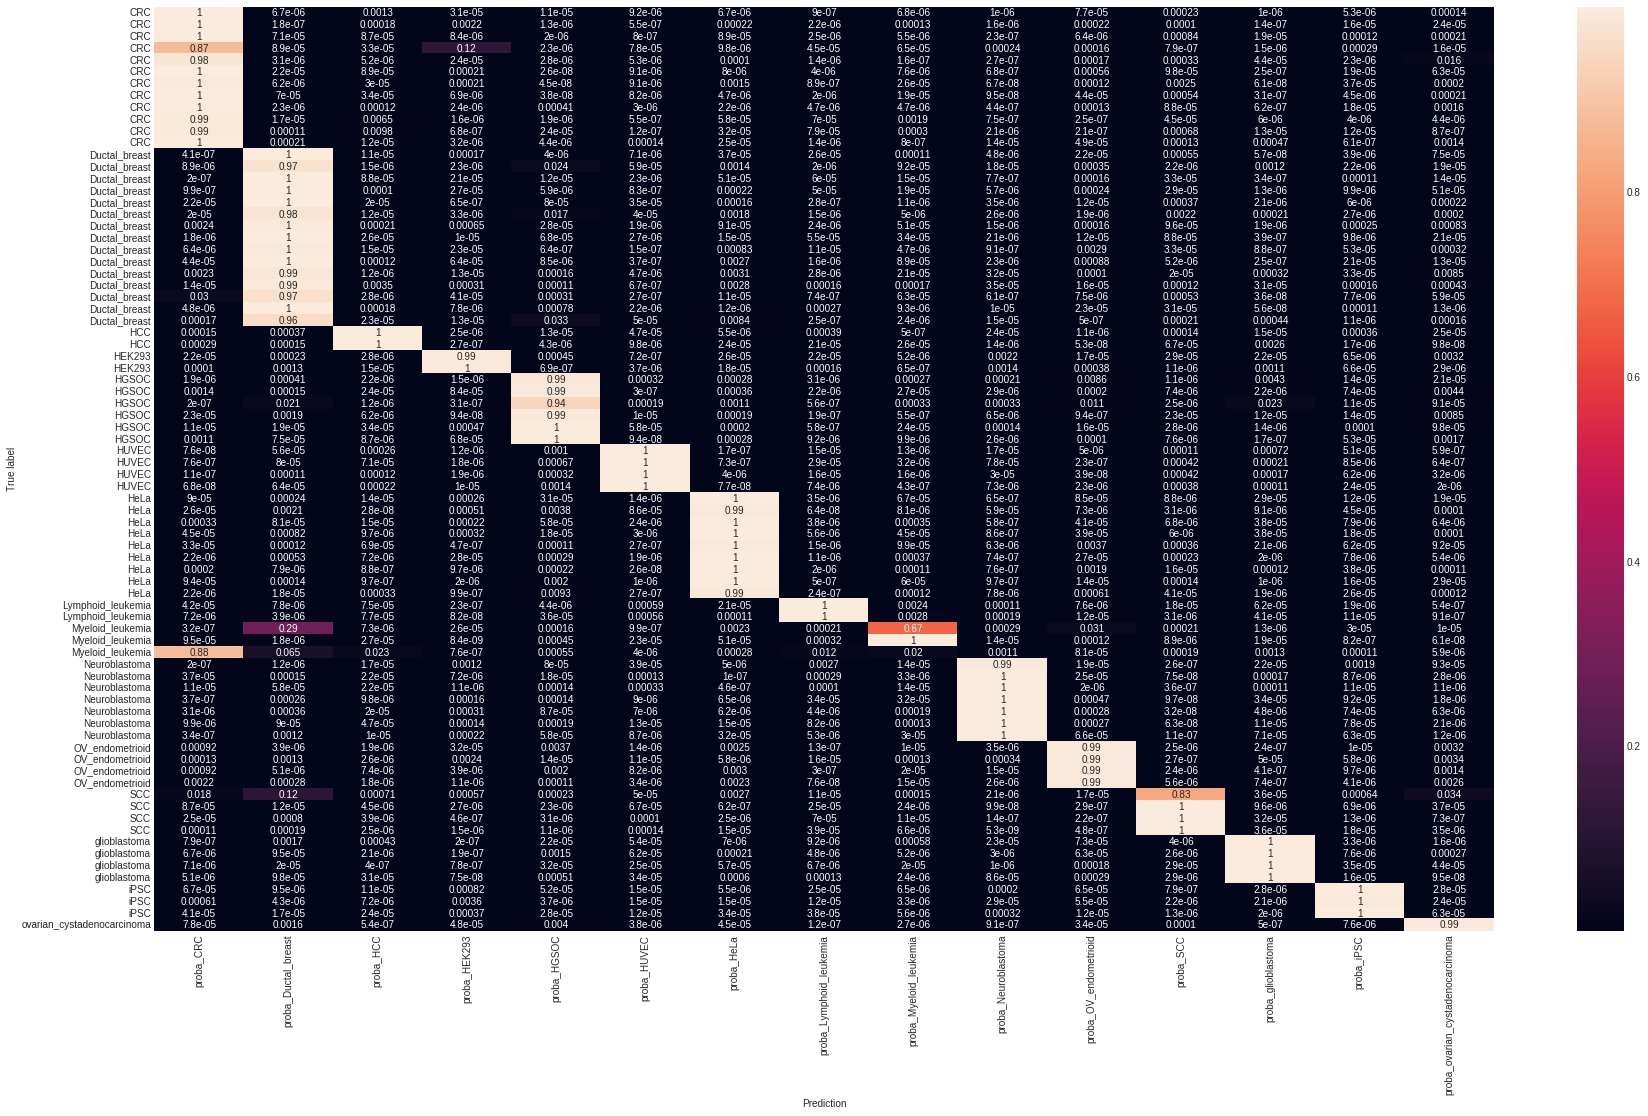

In [16]:
predictions_lr = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_lr_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_lr["correct"] = predictions_lr.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_lr = model_smote_1.predict_proba(X_test)
predictions_lr = pd.concat([predictions_lr, pd.DataFrame(proba_predictions_lr, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_smote_1.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_lr.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

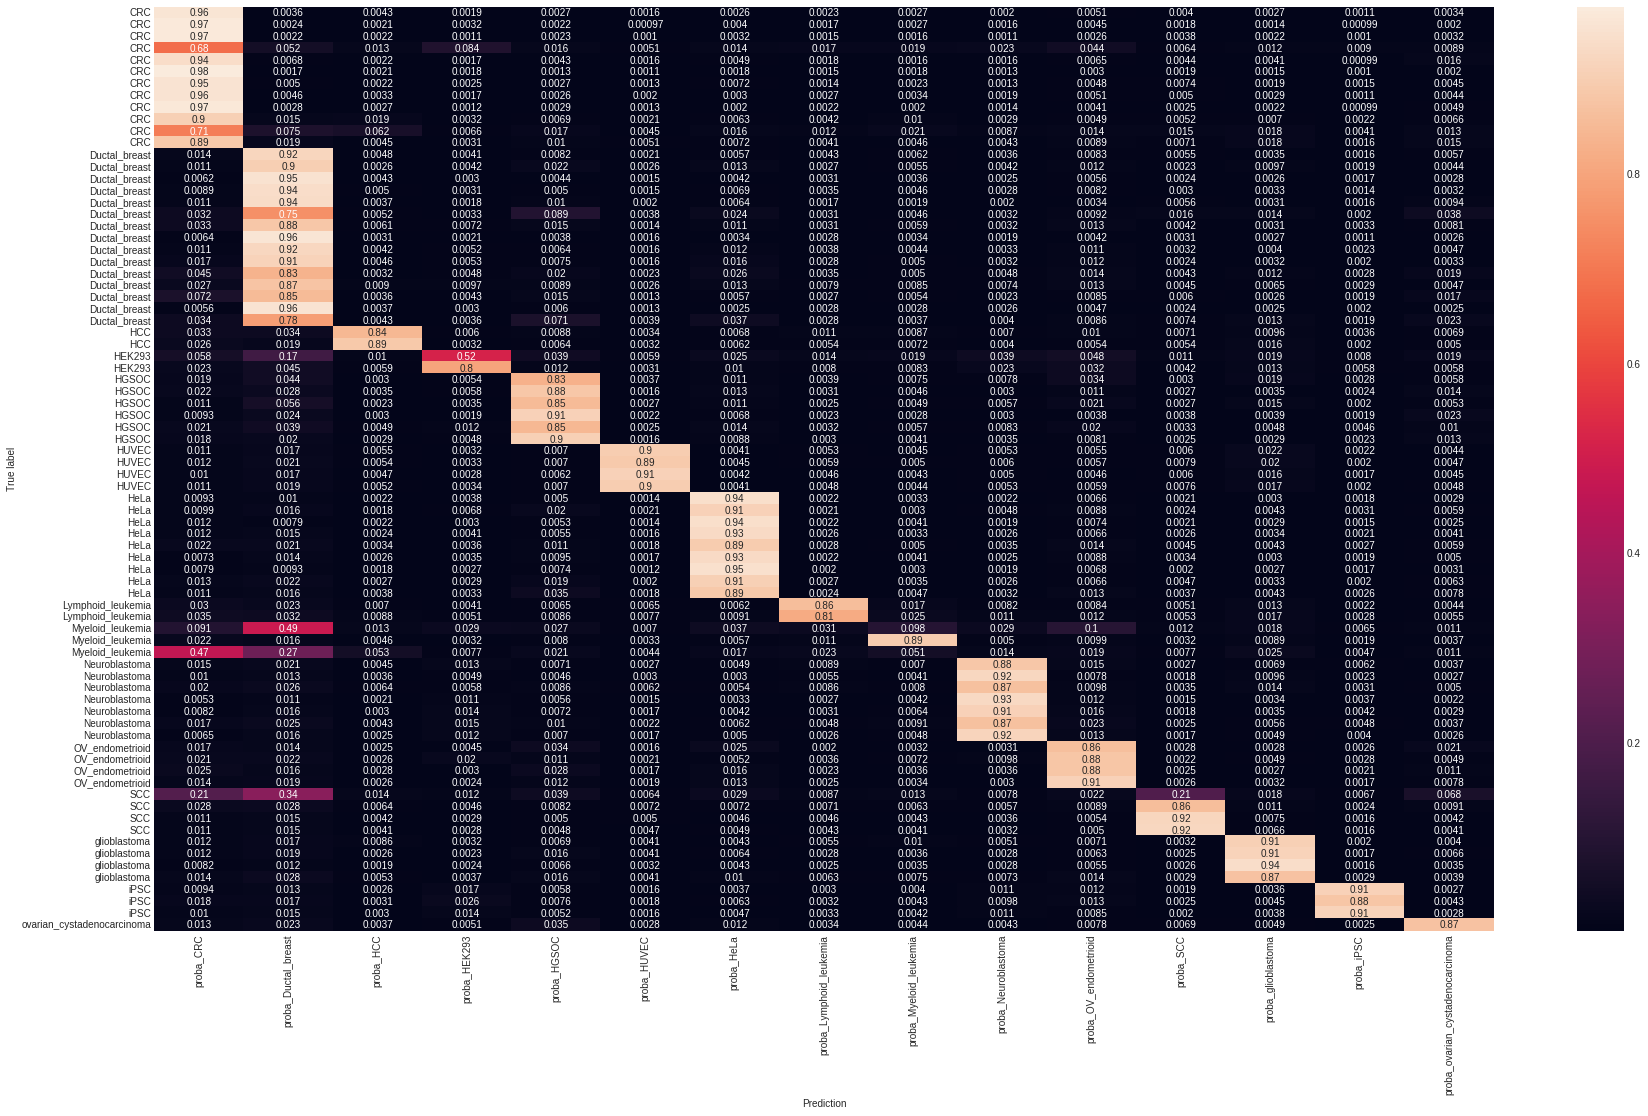

In [33]:
predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_svc_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_svc = model_smote_2.predict_proba(X_test)
predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_smote_2.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_svc.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

X does not have valid feature names, but SVC was fitted with feature names


Text(252.5, 0.5, 'True label')

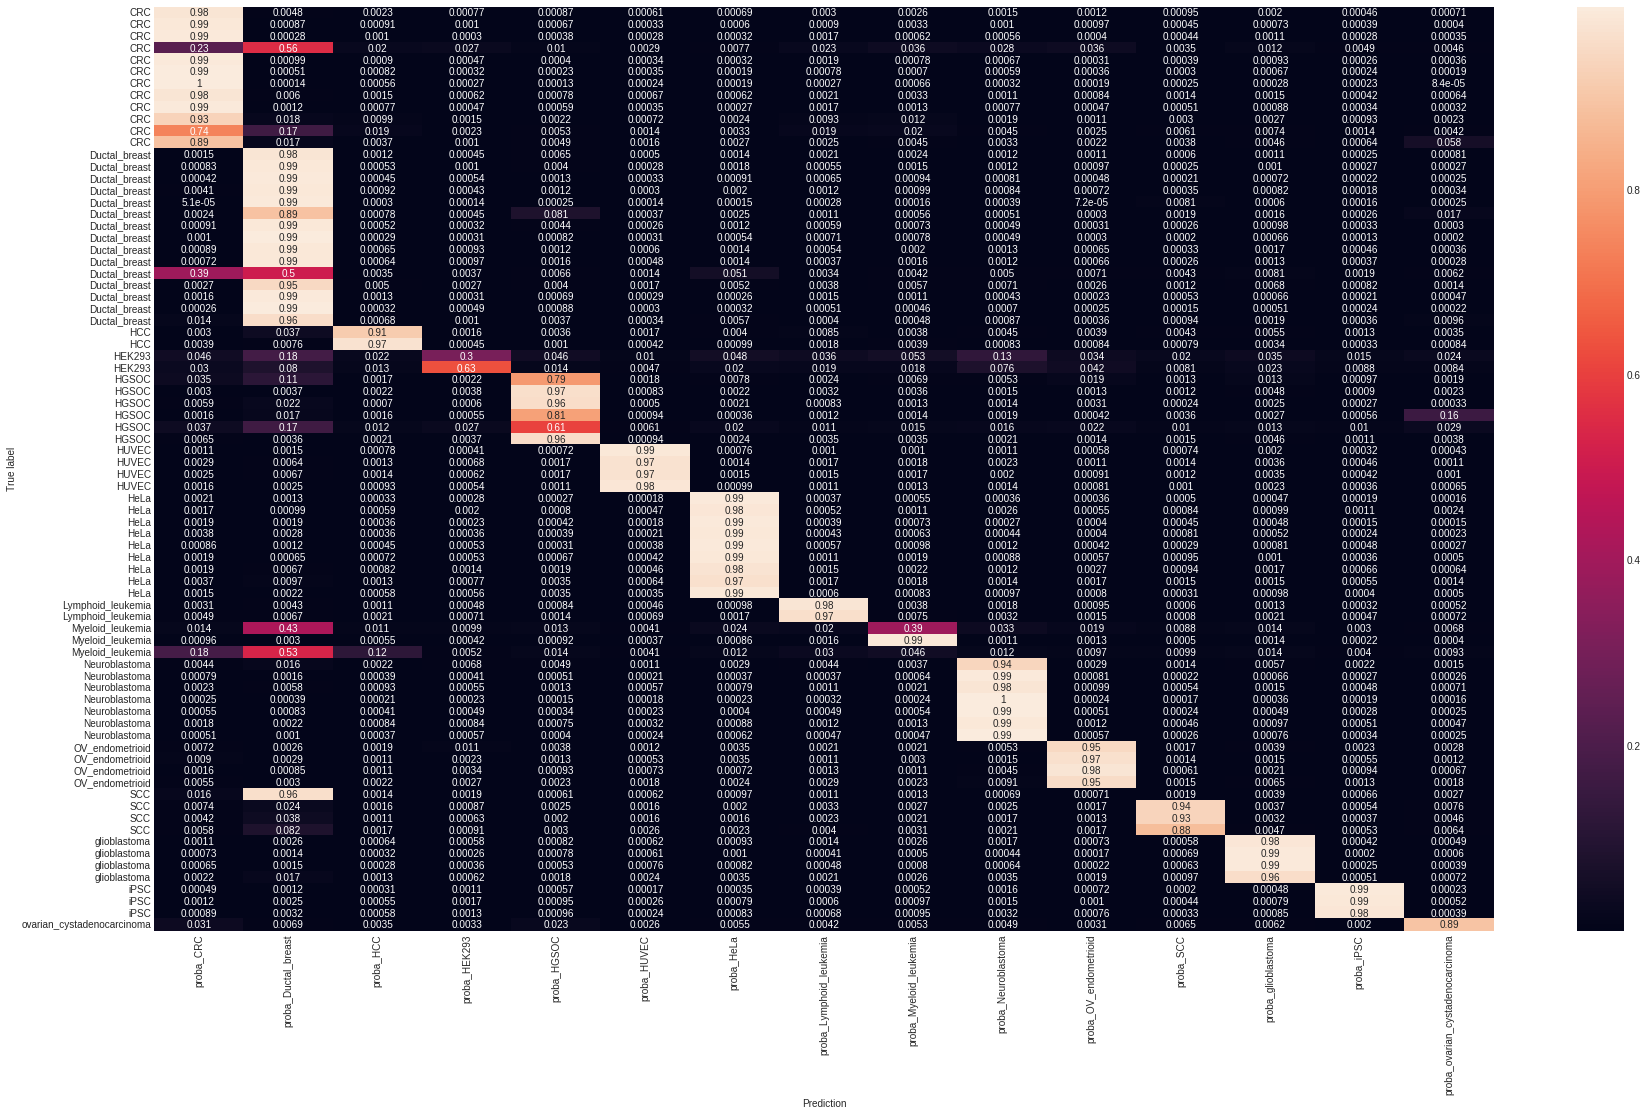

In [32]:
predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_svc_vae), 'label': target_encoder.inverse_transform(y_test)})
predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_svc = model_vae_2.predict_proba(X_test)
predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_vae_2.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_svc.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

X does not have valid feature names, but PCA was fitted with feature names


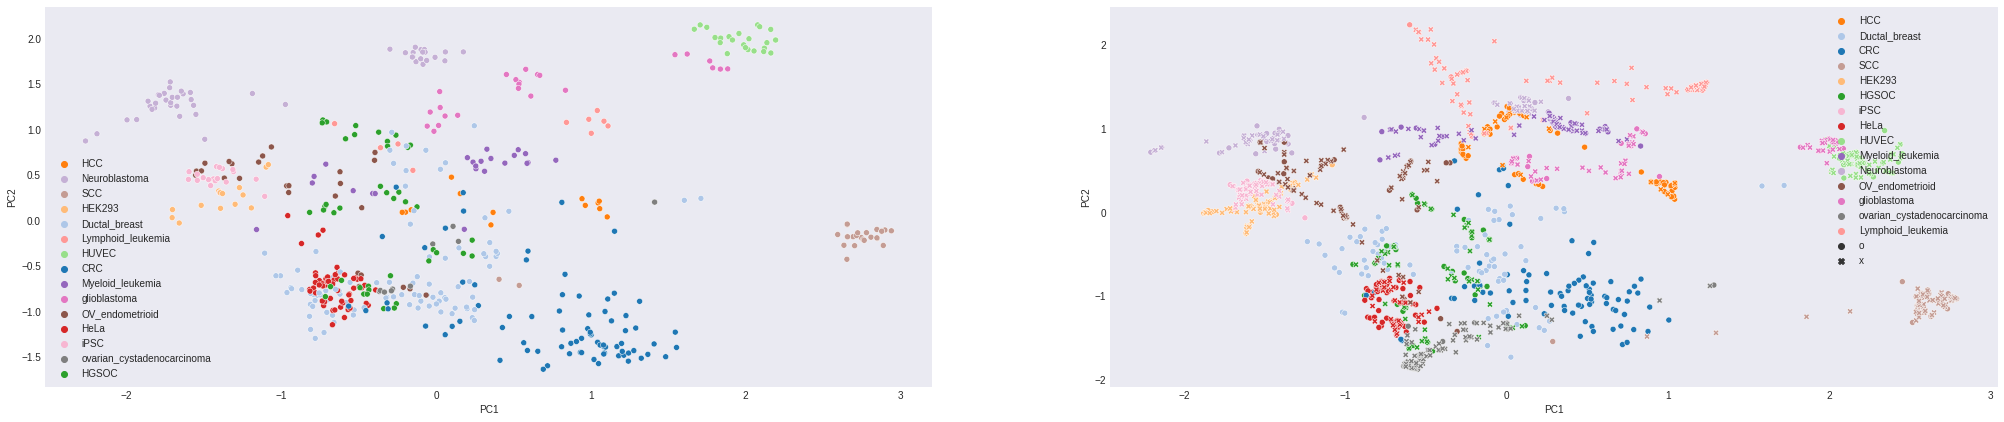

In [21]:
# oversample with smotetomek and check generated samples
colors = sns.color_palette("tab20")[:15]
colors = {target_encoder.inverse_transform([x])[0]: colors[x] for x in unique_labels}
pca = PCA(n_components=2)

pca.fit(quant_imputed)
embedding_original = pca.transform(no_label_quant_imputed)
embedding_sampled = PCA(n_components=2).fit_transform(pd.concat([smote_oversampled]))

fig, ax = plt.subplots(1,2, figsize = (35,7))

sns.scatterplot(data=pd.DataFrame(embedding_original, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = target_encoder.inverse_transform(targets), palette = colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embedding_sampled, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = list(target_encoder.inverse_transform(y_oversampled)), palette = colors, 
                ax=ax[1], style = ["o"]*518+["x"]* (len(y_oversampled)-518))

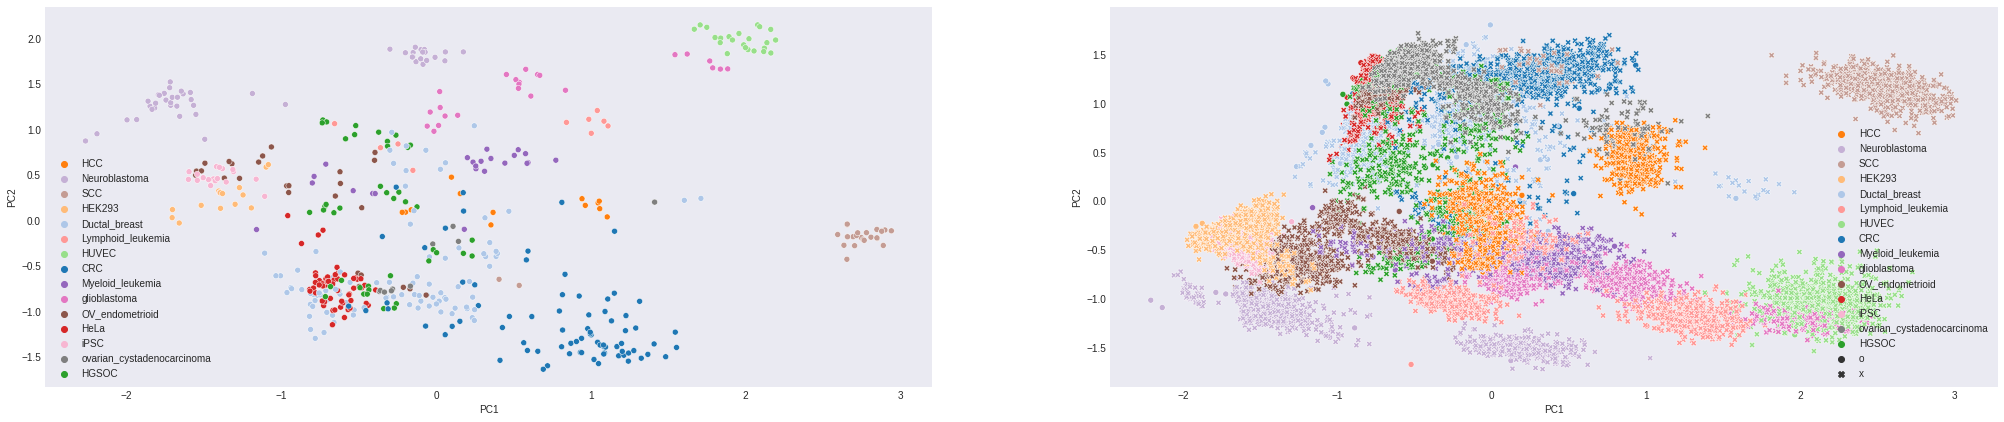

In [22]:
# oversample with smotetomek and check generated samples

pca = PCA(n_components=2)

pca.fit(quant_imputed)
embedding_original = pca.transform(quant_imputed)
embedding_sampled = PCA(n_components=2).fit_transform(pd.concat([quant_imputed,vae_oversampled]))

fig, ax = plt.subplots(1,2, figsize = (35,7))

sns.scatterplot(data=pd.DataFrame(embedding_original, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = target_encoder.inverse_transform(targets), palette = colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embedding_sampled, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = list(target_encoder.inverse_transform(targets))+list(target_encoder.inverse_transform(y_vae)), palette = colors, 
                ax=ax[1], style = ["o"]*518+["x"]* len(y_vae))

In [27]:
meta.iloc[[26,339,24,17]]

project_id           filename  cell_id cell_line  \
assay_id                                                     
31156           1819   A431_control_1_1      555      A431   
33127           1874             q01707      640   HCC1806   
31154           1819   A431_1uM_DON_3_1      554      A431   
31147           1819  A431_10uM_DON_2_2      554      A431   

                               disease       treatment tissue_type sub_cell  \
assay_id                                                                      
31156     Skin squamous cell carcinoma               /        skin        /   
33127                        carcinoma               /      breast        /   
31154     Skin squamous cell carcinoma  deoxynivalenol        skin        /   
31147     Skin squamous cell carcinoma  deoxynivalenol        skin        /   

          organ_id PXD_accession  all_PSM  sign_PSM  peptides  proteins  \
assay_id                                                                  
31156          NaN     PXD008996    92878     21295      7069      1480   
33127          NaN     PXD008222   120879     19885      6987      1720   
31154          NaN     PXD008996    90903     19542      6535      1425   
31147          NaN     PXD008996    81661     17324      5636      1290   

         experiment_type  instrument      pmid  pool_id ionbot_version Group  
assay_id                                                                      
31156             in-gel  Q-exactive  30054545        0  IONBOT_v0.6.2   SCC  
33127        in-solution  Q-exactive  28843283        9  IONBOT_v0.7.0   SCC  
31154             in-gel  Q-exactive  30054545        0  IONBOT_v0.6.2   SCC  
31147             in-gel  Q-exactive  30054545        0  IONBOT_v0.6.2   SCC

In [13]:
explainer_cpu_lr = shap.LinearExplainer(model_smote_1, X_train)
shap_values_lr_test = explainer_cpu_lr.shap_values(X_test)
shap_values_lr_train = explainer_cpu_lr.shap_values(X_train)
print("LR explained")

LR explained


In [14]:
explainer_cpu_svc = shap.KernelExplainer(model_smote_2.predict_proba, X_train)
shap_values_svc_test = explainer_cpu_svc.shap_values(X_test)
shap_values_svc_train = expslainer_cpu_svc.shap_values(X_train)
print("svc explained")

Using 440 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [15]:
feature_names = list(data_quant.columns)

In [20]:
sv = explainer_cpu_lr(X_train)

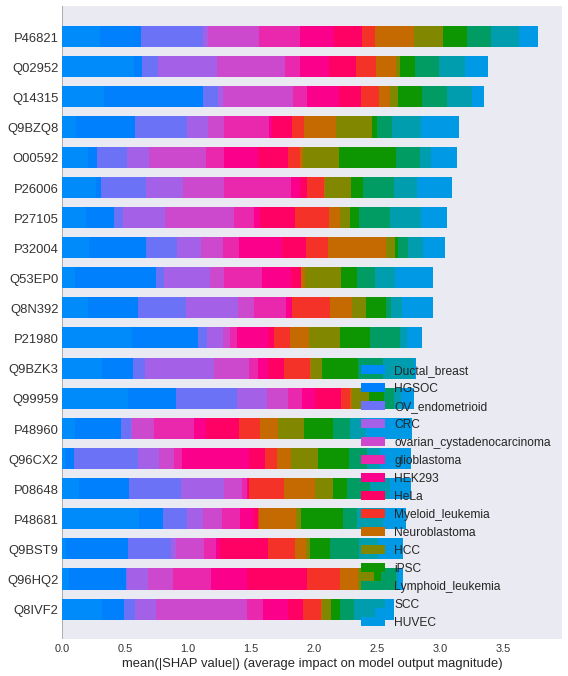

In [16]:
shap.summary_plot(shap_values_lr_train, X_train.values, plot_type="bar", class_names= target_encoder.inverse_transform(model_smote_1.classes_), feature_names = feature_names)

In [18]:
from shap import TreeExplainer, Explanation


In [ ]:
explainer = KernelExplainer(model.predict, X)
sv = explainer.shap_values(X.loc[[5]])   # pass the row of interest as df

exp = Explanation(sv[4], explainer.expected_value, data=X.loc[[idx]].values, feature_names=X.columns)
waterfall(exp[0])

In [90]:
target_encoder.inverse_transform([y_train[19]])

array(['Neuroblastoma'], dtype=object)

In [107]:
# compute sum of SHAP values for each instance
shap_sum = np.sum(sv.values, axis=1)

# compute softmax of class-specific SHAP values
shap_softmax = np.exp(sv.values) / np.exp(sv.values).sum(axis=1, keepdims=True)

# compute final probabilities by multiplying softmax values by shap sum
probs = shap_softmax * shap_sum[:, np.newaxis]

In [110]:
probs.shape

(440, 161, 15)

In [117]:
X_train.iloc[4,:]

0      0.423384
1      0.312005
2      0.549487
3      0.665666
4      0.207591
         ...   
156    0.534531
157    0.817220
158    0.178211
159    0.359882
160    0.727186
Name: 470, Length: 161, dtype: float64

In [121]:
model_smote_1.predict_proba(X_train)[4]

array([9.97373003e-01, 3.67424508e-04, 6.06565904e-07, 2.57402507e-05,
       3.21622892e-06, 1.68888802e-05, 2.59775363e-04, 5.59858602e-07,
       2.28838892e-07, 2.55444579e-06, 5.20051518e-05, 4.04969850e-04,
       2.74691712e-05, 9.39414893e-06, 1.45616412e-03])

In [132]:
X_train.reset_index(drop=True).rename(columns = {x:data_quant.columns[x] for x in range(161)}).loc[4,:].sort_values(ascending=True)

P48735    0.000000
P35580    0.072825
Q8TEM1    0.094847
P16403    0.105674
P61978    0.107718
            ...   
Q9UHR4    0.897669
Q96TA1    0.929880
Q16658    0.939144
Q9UQE7    0.942694
Q02952    1.000000
Name: 4, Length: 161, dtype: float64

In [123]:
expit(2.5)

0.9241418199787566

In [22]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train.values, 
                  feature_names=features)
idx = 4
shap.force_plot(exp[idx], link="logit")

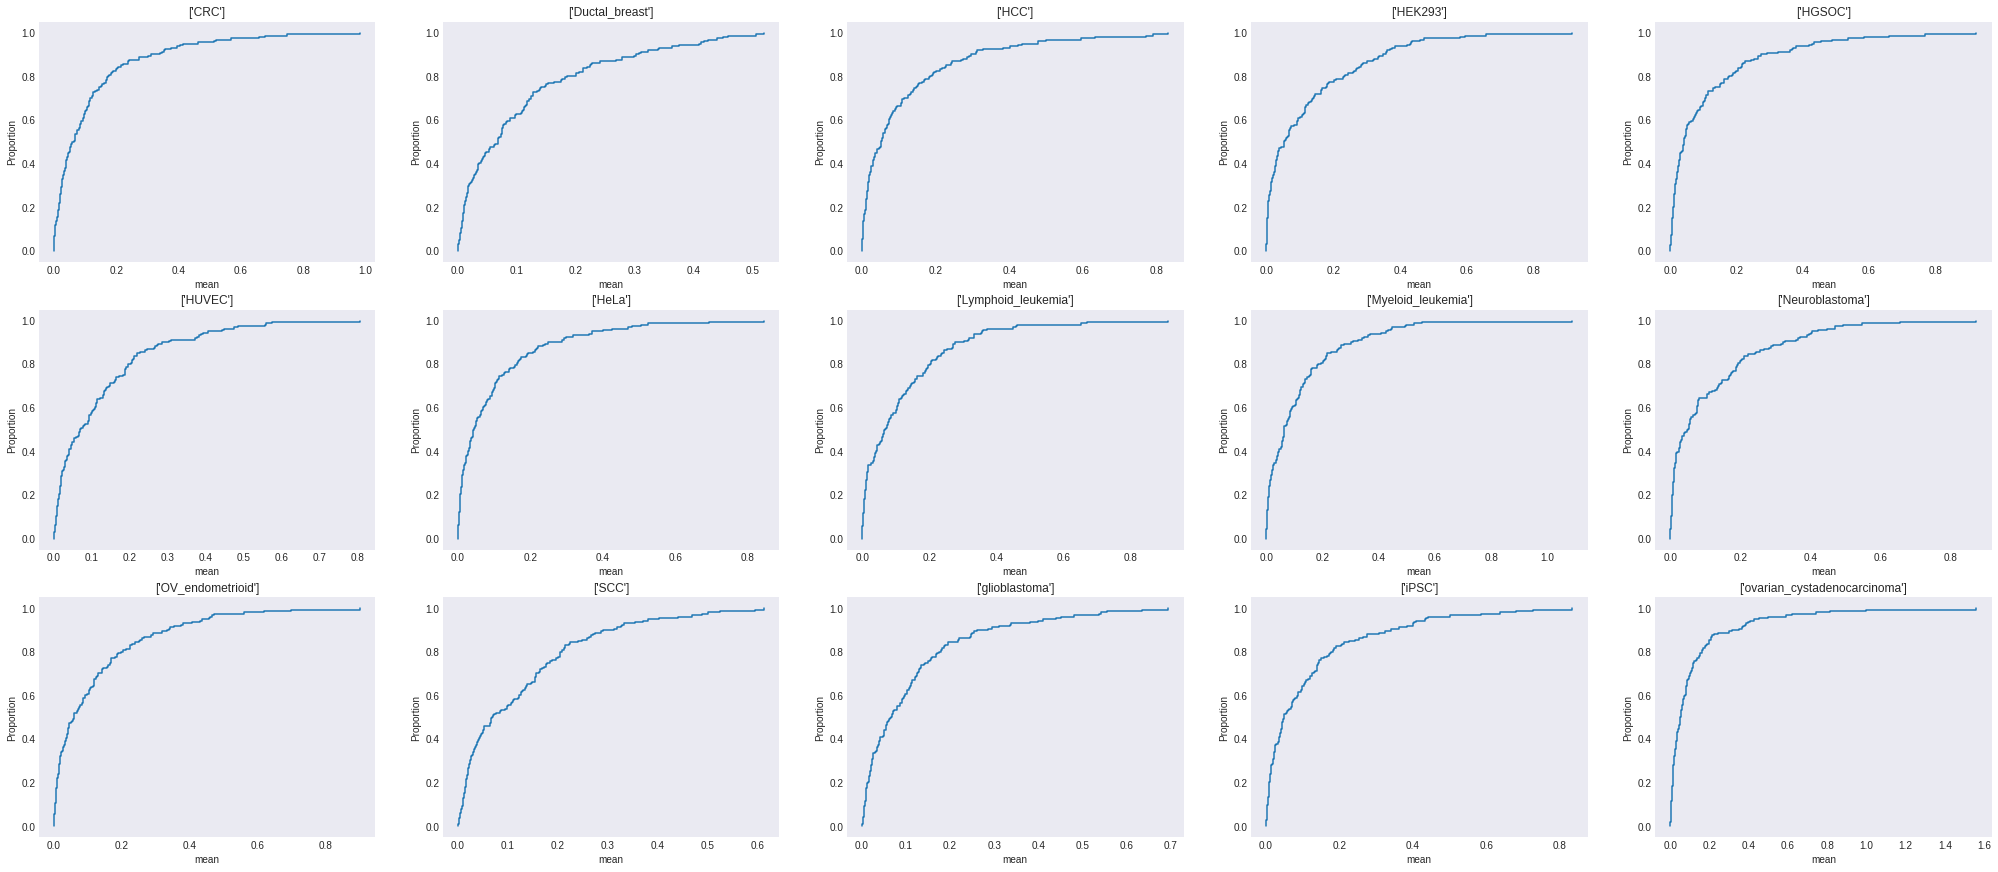

In [24]:
fig, ax = plt.subplots(3,5, figsize=(35,15))

y_axis = 0
x_axis = 0
for i in range(15):
    
    # Get the table of shap values for class i
    shaps_df = pd.DataFrame(shap_values_lr_train[i], columns=feature_names)

    # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train == i,:].mean(), columns = ["mean"])
    stat_shaps_df["std"] = shaps_df.loc[y_train == i,:].std()

    # Create cumulative distribution plot of the mean shap value of the proteins to see whether a few proteins have large shap value means for each class
    # This enables to inituitively select top % features based on their shap values
    ax[x_axis][y_axis].set_title(target_encoder.inverse_transform([i]))
    sns.ecdfplot(abs(stat_shaps_df['mean']), ax=ax[x_axis][y_axis])

    y_axis += 1
    if y_axis == 5:
        y_axis=0
        x_axis+=1

In [98]:
from scipy.special import expit

In [68]:
shap.plots.waterfall(explainer_cpu_lr.expected_value[0], shap_values_cpu_lr_train[0][4], X_train.iloc[4])

AttributeError: 'numpy.float64' object has no attribute 'base_values'

---

In [3]:
param_grid = ParameterGrid({
        "filtering__percentage": [.3,.5,.8],
        "clf__penalty" : ['l2', 'l1', 'elasticnet'],
        "clf__max_iter": [10000],
        "clf__class_weight": [None, weights],
        "clf__C": np.linspace(0.005, 15, 10),
        'clf__solver': ['newton-cg', 'saga', 'lbfgs', "liblinear"]})

valid_grids = []
for grid in param_grid:
    if grid['clf__solver'] in 'newton-cg sag lbfgs'.split() and grid['clf__penalty'] in 'l1 elaticnet'.split():
        continue
    if grid['clf__penalty'] == 'elasticnet' and grid['clf__solver'] != 'saga':
        continue

    grid_ = {item[0]: [item[1]] for item in grid.items()}
    valid_grids.append(grid_)

In [ ]:
# Fit model

pipe_bio = PipeIMBL(steps=[
    ('filtering', uml.FilterByClass(keep=True,percentage=.7)),
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler()),
    ('oversample', SMOTETomek()),
    ('clf', LogisticRegression())
    ])

pipe_glob = PipeIMBL(steps=[
    ('filtering', uml.FilterByOccurence(.5)),
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler()),
    ('oversample', SMOTETomek()),
    ('clf', LogisticRegression())
    ])

best_params = []
grid_scores = []
features = []

skf = StratifiedKFold(10, shuffle=True)
for train, test in skf.split(X = data, y = targets):

    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    grid_search = RandomizedSearchCV(pipe_glob, valid_grids, n_iter = 20, scoring='f1_micro', cv = 5)
    grid_search.fit(X_train, Y_train)

    best_params.append(grid_search.best_params_)
    grid_scores.append(grid_search.best_score_)

    Y_pred = grid_search.predict(X_test)

    test_score = f1_score(Y_test, Y_pred, labels= unique_labels,average='f1_micro')
    print('Grid score: {}\nScore: {}\nParams: {}\n'.format(grid_search.best_score_, test_score, grid_search.best_params_))

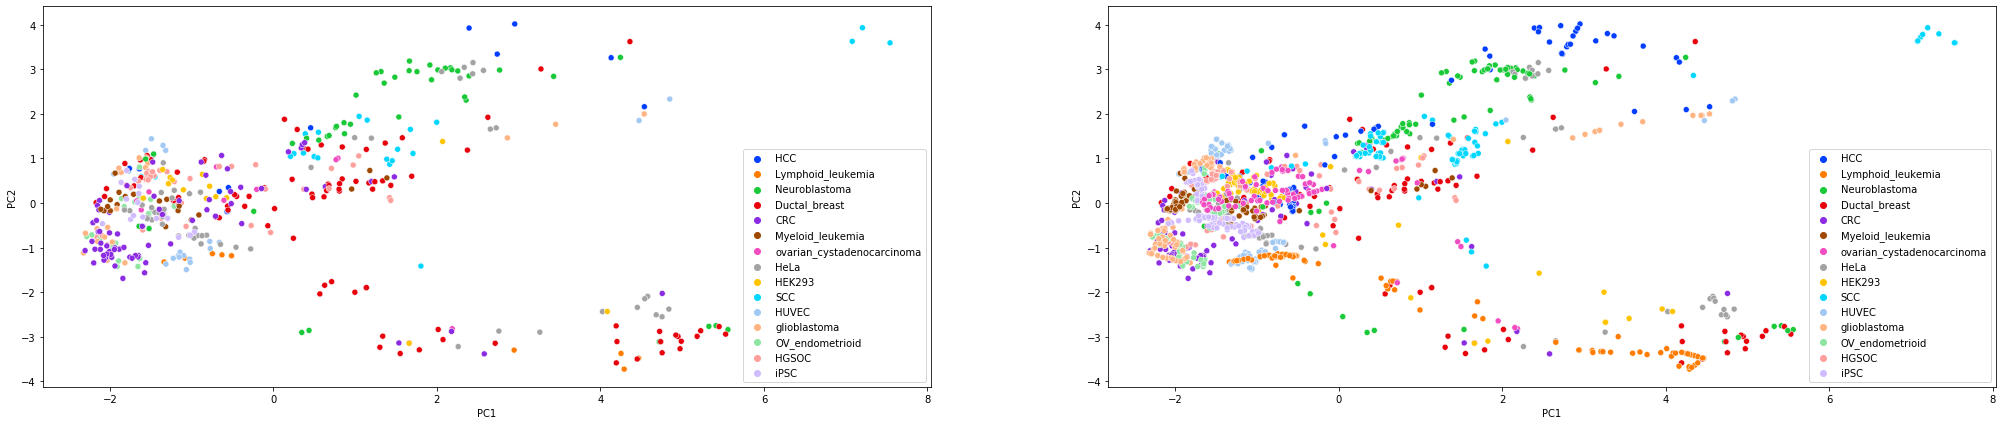

In [57]:
# oversample with smotetomek and check generated samples
oversampler = SMOTETomek()
X_tomek, y_tomek = oversampler.fit_resample(X_train_prep, Y_train)

pca = PCA(n_components=2)

pca.fit(X_train_prep)
embedding_original = pca.transform(X_train_prep)
embedding_sampled = pca.transform(X_tomek)

fig, ax = plt.subplots(1,2, figsize = (35,7))

sns.scatterplot(data=pd.DataFrame(embedding_original, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = target_encoder.inverse_transform(Y_train), palette = colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embedding_sampled, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = target_encoder.inverse_transform(y_tomek), palette = colors, ax=ax[1])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, targets,
                                                    stratify=targets, 
                                                    test_size=0.15,
                                                    random_state=42)

In [10]:
preprocessor_bio = Pipeline(steps=[
    ('filtering', uml.FilterByClass(keep=True, percentage=.7)),
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

preprocessor_bio.fit(X_train, y_train)
X_train_processed = preprocessor_bio.transform(X_train)
X_test_processed = preprocessor_bio.transform(X_test)

X_train_oversampled, y_oversampled = SMOTETomek().fit_resample(X_train_processed, y_train)

model_bio_lr = LogisticRegression(max_iter=10000, C=20, solver="liblinear", penalty="l1", class_weight=weights)
model_bio_svc = SVC(probability=True, kernel="linear", C=1, class_weight=weights, decision_function_shape="ovr")
model_bio_rf = RandomForestClassifier(n_estimators=150, criterion="entropy", max_depth=40, class_weight=weights)
model_bio_gnb = GaussianNB(var_smoothing=.15)

model_bio_lr.fit(X_train_oversampled, y_oversampled)
model_bio_svc.fit(X_train_oversampled, y_oversampled)
model_bio_rf.fit(X_train_oversampled, y_oversampled)
model_bio_gnb.fit(X_train_oversampled, y_oversampled)

Y_pred_lr = model_bio_lr.predict(X_test_processed)
Y_pred_svc = model_bio_svc.predict(X_test_processed)
Y_pred_rf = model_bio_rf.predict(X_test_processed)
Y_pred_gnb = model_bio_gnb.predict(X_test_processed)

print("Score LR:  ", f1_score(y_test, Y_pred_lr, labels=unique_labels, average='micro'))
print("Score SVC: ", f1_score(y_test, Y_pred_svc, labels=unique_labels, average='micro'))
print("Score RF:  ", f1_score(y_test, Y_pred_rf, labels=unique_labels, average='micro'))
print("Score GNB:  ", f1_score(y_test, Y_pred_gnb, labels=unique_labels, average='micro'))

Score LR:   0.9743589743589743
Score SVC:  0.9615384615384616
Score RF:   0.9487179487179487
Score GNB:   0.7564102564102565


In [11]:
preprocessor_glob = Pipeline(steps=[
    ('filtering', uml.FilterByOccurence(.5)),
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

model_glob_lr = LogisticRegression(max_iter=10000, C=20, solver="liblinear", penalty="l1", class_weight=weights)
model_glob_svc = SVC(probability=True, kernel="linear", C=1, class_weight=weights, decision_function_shape="ovr")
model_glob_rf = RandomForestClassifier(n_estimators=150, criterion="entropy", max_depth=40, class_weight=weights)
model_glob_gnb = GaussianNB(var_smoothing=.15)

preprocessor_glob.fit(X_train, y_train)
X_train_processed_glob = preprocessor_glob.transform(X_train)
X_test_processed_glob = preprocessor_glob.transform(X_test)

X_train_oversampled_glob, y_oversampled_glob = SMOTETomek().fit_resample(X_train_processed_glob, y_train)

X_train_oversampled_glob = pd.DataFrame(X_train_oversampled_glob, columns= preprocessor_glob.named_steps.filtering.filtered_proteins)
X_train_processed_glob = pd.DataFrame(X_train_processed_glob, columns= preprocessor_glob.named_steps.filtering.filtered_proteins)
X_test_processed_glob = pd.DataFrame(X_test_processed_glob, columns= preprocessor_glob.named_steps.filtering.filtered_proteins)

model_glob_lr.fit(X_train_oversampled_glob, y_oversampled_glob)
model_glob_svc.fit(X_train_oversampled_glob, y_oversampled_glob)
model_glob_rf.fit(X_train_oversampled_glob, y_oversampled_glob)
model_glob_gnb.fit(X_train_oversampled_glob, y_oversampled_glob)

Y_pred_glob_lr = model_glob_lr.predict(X_test_processed_glob)
Y_pred_glob_svc = model_glob_svc.predict(X_test_processed_glob)
Y_pred_glob_rf = model_glob_rf.predict(X_test_processed_glob)
Y_pred_glob_gnb = model_glob_gnb.predict(X_test_processed_glob)

print("Score LR:  ", f1_score(y_test, Y_pred_glob_lr, labels=unique_labels, average='micro'))
print("Score SVC: ", f1_score(y_test, Y_pred_glob_svc, labels=unique_labels, average='micro'))
print("Score RF:  ", f1_score(y_test, Y_pred_glob_rf, labels=unique_labels, average='micro'))
print("Score GNB:  ", f1_score(y_test, Y_pred_glob_gnb, labels=unique_labels, average='micro'))

Score LR:   0.9743589743589743
Score SVC:  0.9615384615384616
Score RF:   0.9487179487179487
Score GNB:   0.7948717948717948


In [ ]:
# Check project split
preprocessor_cpu = Pipeline(steps=[
    ('filtering', uml.FilterByOccurence(.5)),
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

splitter = uml.ProjectBasedSplit(10, meta, on="Group")

fold=0
for train, test in splitter.split(data, None):
    
    fold += 1
    print(fold)
    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    model_cpu_lr = LogisticRegression(max_iter=10000, C=20, solver="liblinear", penalty="l1", class_weight=weights)
    model_cpu_svc = SVC(probability=True, kernel="linear", C=1, class_weight=weights, decision_function_shape="ovr")
    model_cpu_rf = RandomForestClassifier(n_estimators=150, criterion="entropy", max_depth=40, class_weight=weights)
    model_cpu_gnb = GaussianNB(var_smoothing=.15)

    preprocessor_cpu.fit(X_train, Y_train)
    X_train_processed_cpu = preprocessor_cpu.transform(X_train)
    X_test_processed_cpu = preprocessor_cpu.transform(X_test)

    X_train_processed_cpu = pd.DataFrame(X_train_processed_cpu, columns= preprocessor_cpu.named_steps.filtering.filtered_proteins)
    X_test_processed_cpu = pd.DataFrame(X_test_processed_cpu, columns= preprocessor_cpu.named_steps.filtering.filtered_proteins)

    feature_selector = uml.FeatureSelector(selectors= ['LR', "MI", 'SVC'], num_features=1000, threshold=.5)
    feature_selector.fit(X_train_processed_cpu, Y_train)
    X_train_processed_cpu = feature_selector.transform(X_train_processed_cpu)
    X_test_processed_cpu = feature_selector.transform(X_test_processed_cpu)

    X_train_oversampled_cpu, y_oversampled_cpu = SMOTETomek(smote=SMOTE(k_neighbors=3)).fit_resample(X_train_processed_cpu, Y_train)

    model_cpu_lr.fit(X_train_oversampled_cpu, y_oversampled_cpu)
    model_cpu_svc.fit(X_train_oversampled_cpu, y_oversampled_cpu)
    model_cpu_rf.fit(X_train_oversampled_cpu, y_oversampled_cpu)
    model_cpu_gnb.fit(X_train_oversampled_cpu, y_oversampled_cpu)

    Y_pred_cpu_lr = model_cpu_lr.predict(X_test_processed_cpu)
    Y_pred_cpu_svc = model_cpu_svc.predict(X_test_processed_cpu)
    Y_pred_cpu_rf = model_cpu_rf.predict(X_test_processed_cpu)
    Y_pred_cpu_gnb = model_cpu_gnb.predict(X_test_processed_cpu)

    print("Score LR:  ", f1_score(Y_test, Y_pred_cpu_lr, labels=unique_labels, average='micro'))
    print("Score SVC: ", f1_score(Y_test, Y_pred_cpu_svc, labels=unique_labels, average='micro'))
    print("Score RF:  ", f1_score(Y_test, Y_pred_cpu_rf, labels=unique_labels, average='micro'))
    print("Score GNB:  ", f1_score(Y_test, Y_pred_cpu_gnb, labels=unique_labels, average='micro'))

    predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_cpu_svc), 'label': target_encoder.inverse_transform(Y_test)})
    predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

    proba_predictions_svc = model_cpu_svc.predict_proba(X_test_processed_cpu)
    predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_cpu_svc.classes_)])], axis = 1)

In [5]:
preprocessor_cpu = Pipeline(steps=[
    ('filtering', uml.FilterByOccurence(.5)),
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

# Models
model_cpu_lr = LogisticRegression(max_iter=10000, C=20, solver="liblinear", penalty="l1", class_weight=weights)
model_cpu_svc = SVC(probability=True, kernel="linear", C=1, class_weight=weights, decision_function_shape="ovr")
model_cpu_rf = RandomForestClassifier(n_estimators=150, criterion="entropy", max_depth=40, class_weight=weights)
model_cpu_gnb = GaussianNB(var_smoothing=.15)

# First preprocessor (global filter)
preprocessor_cpu.fit(X_train, y_train)
X_train_processed_cpu = preprocessor_cpu.transform(X_train)
X_test_processed_cpu = preprocessor_cpu.transform(X_test)

X_train_processed_cpu = pd.DataFrame(X_train_processed_cpu, columns= preprocessor_cpu.named_steps.filtering.filtered_proteins)
X_test_processed_cpu = pd.DataFrame(X_test_processed_cpu, columns= preprocessor_cpu.named_steps.filtering.filtered_proteins)

# More feature selection
feature_selector = uml.FeatureSelector(selectors= ['LR', "MI", 'SVC'], num_features=1000, threshold=.5)
feature_selector.fit(X_train_processed_cpu, y_train)
X_train_processed_cpu = feature_selector.transform(X_train_processed_cpu)
X_test_processed_cpu = feature_selector.transform(X_test_processed_cpu)

# Oversample
X_train_oversampled_cpu, y_oversampled_cpu = SMOTETomek().fit_resample(X_train_processed_cpu, y_train)

# Train models
model_cpu_lr.fit(X_train_oversampled_cpu, y_oversampled_cpu)
model_cpu_svc.fit(X_train_oversampled_cpu, y_oversampled_cpu)
model_cpu_rf.fit(X_train_oversampled_cpu, y_oversampled_cpu)
model_cpu_gnb.fit(X_train_oversampled_cpu, y_oversampled_cpu)

Y_pred_cpu_lr = model_cpu_lr.predict(X_test_processed_cpu)
Y_pred_cpu_svc = model_cpu_svc.predict(X_test_processed_cpu)
Y_pred_cpu_rf = model_cpu_rf.predict(X_test_processed_cpu)
Y_pred_cpu_gnb = model_cpu_gnb.predict(X_test_processed_cpu)

print("Score LR:  ", f1_score(y_test, Y_pred_cpu_lr, labels=unique_labels, average='micro'))
print("Score SVC: ", f1_score(y_test, Y_pred_cpu_svc, labels=unique_labels, average='micro'))
print("Score RF:  ", f1_score(y_test, Y_pred_cpu_rf, labels=unique_labels, average='micro'))
print("Score GNB:  ", f1_score(y_test, Y_pred_cpu_gnb, labels=unique_labels, average='micro'))

Score LR:   0.9615384615384616
Score SVC:  0.9615384615384616
Score RF:   0.9487179487179487
Score GNB:   0.8461538461538461


In [37]:
bio_proteins = preprocessor_bio.named_steps.filtering.filtered_proteins
glob_proteins = preprocessor_glob.named_steps.filtering.filtered_proteins
cpu_proteins = X_train_processed_cpu.columns

In [11]:
shap_features_cpu = list(X_train_processed_cpu.columns)

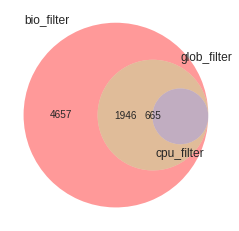

In [39]:
plt.figure(facecolor='white')
venn.venn3([set(bio_proteins), set(glob_proteins), set(cpu_proteins)], ("bio_filter", "glob_filter", 'cpu_filter'))

In [49]:
shap_features_bio = list(preprocessor_bio.named_steps.filtering.filtered_proteins)
shap_features_glob = list(preprocessor_glob.named_steps.filtering.filtered_proteins)
shap_features_cpu = list(X_train_processed_cpu.columns)

In [40]:
train_targets = pd.DataFrame(data=y_train, columns = ["Encoding"])
train_targets["Label_name"] = train_targets.apply(lambda x: target_encoder.inverse_transform(x))

How are the test samples predicted?

In [12]:
predictions_lr = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_cpu_lr), 'label': target_encoder.inverse_transform(y_test)})
predictions_lr["correct"] = predictions_lr.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_lr = model_cpu_lr.predict_proba(X_test_processed_cpu)
predictions_lr = pd.concat([predictions_lr, pd.DataFrame(proba_predictions_lr, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_cpu_lr.classes_)])], axis = 1)


predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_cpu_svc), 'label': target_encoder.inverse_transform(y_test)})
predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_svc = model_cpu_svc.predict_proba(X_test_processed_cpu)
predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_cpu_svc.classes_)])], axis = 1)


predictions_rf = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_cpu_rf), 'label': target_encoder.inverse_transform(y_test)})
predictions_rf["correct"] = predictions_rf.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_rf = model_cpu_rf.predict_proba(X_test_processed_cpu)
predictions_rf = pd.concat([predictions_rf, pd.DataFrame(proba_predictions_rf, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_cpu_rf.classes_)])], axis = 1)


predictions_gnb = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_cpu_gnb), 'label': target_encoder.inverse_transform(y_test)})
predictions_gnb["correct"] = predictions_rf.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)

proba_predictions_gnb = model_cpu_gnb.predict_proba(X_test_processed_cpu)
predictions_gnb = pd.concat([predictions_gnb, pd.DataFrame(proba_predictions_gnb, columns = ['proba_'+x for x in target_encoder.inverse_transform(model_cpu_gnb.classes_)])], axis = 1)

Text(252.5, 0.5, 'True label')

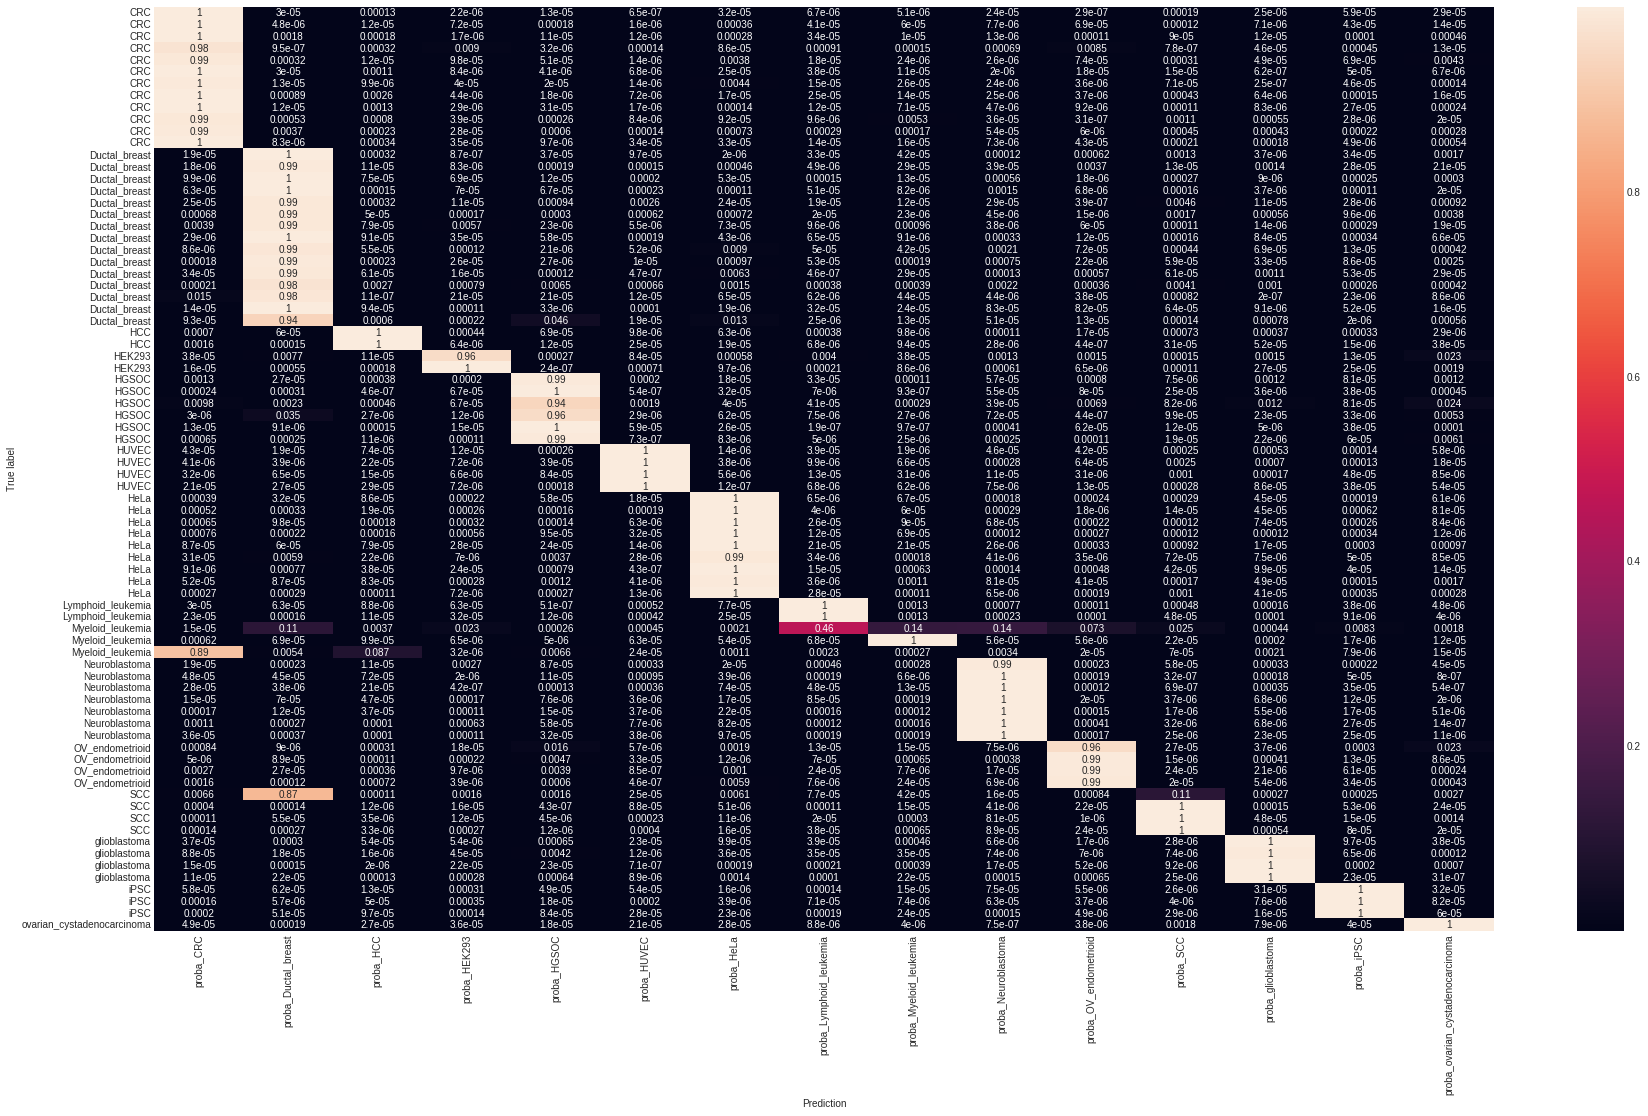

In [13]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_lr.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

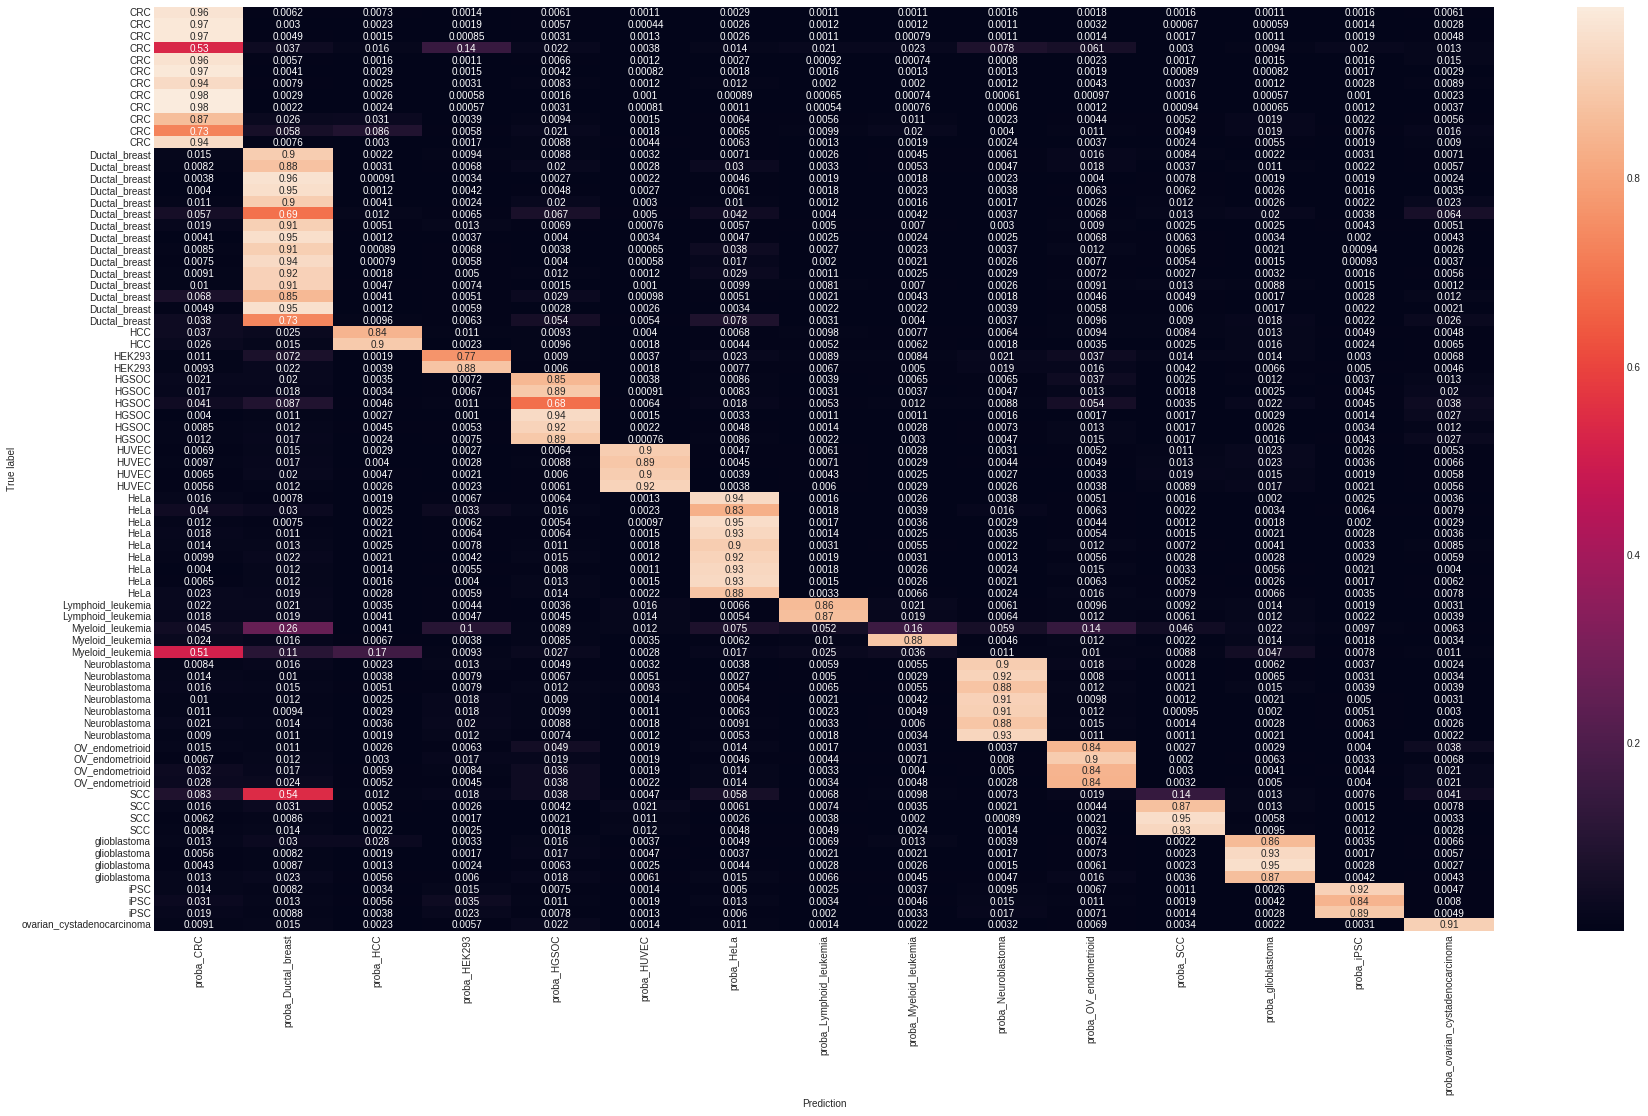

In [44]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_svc.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

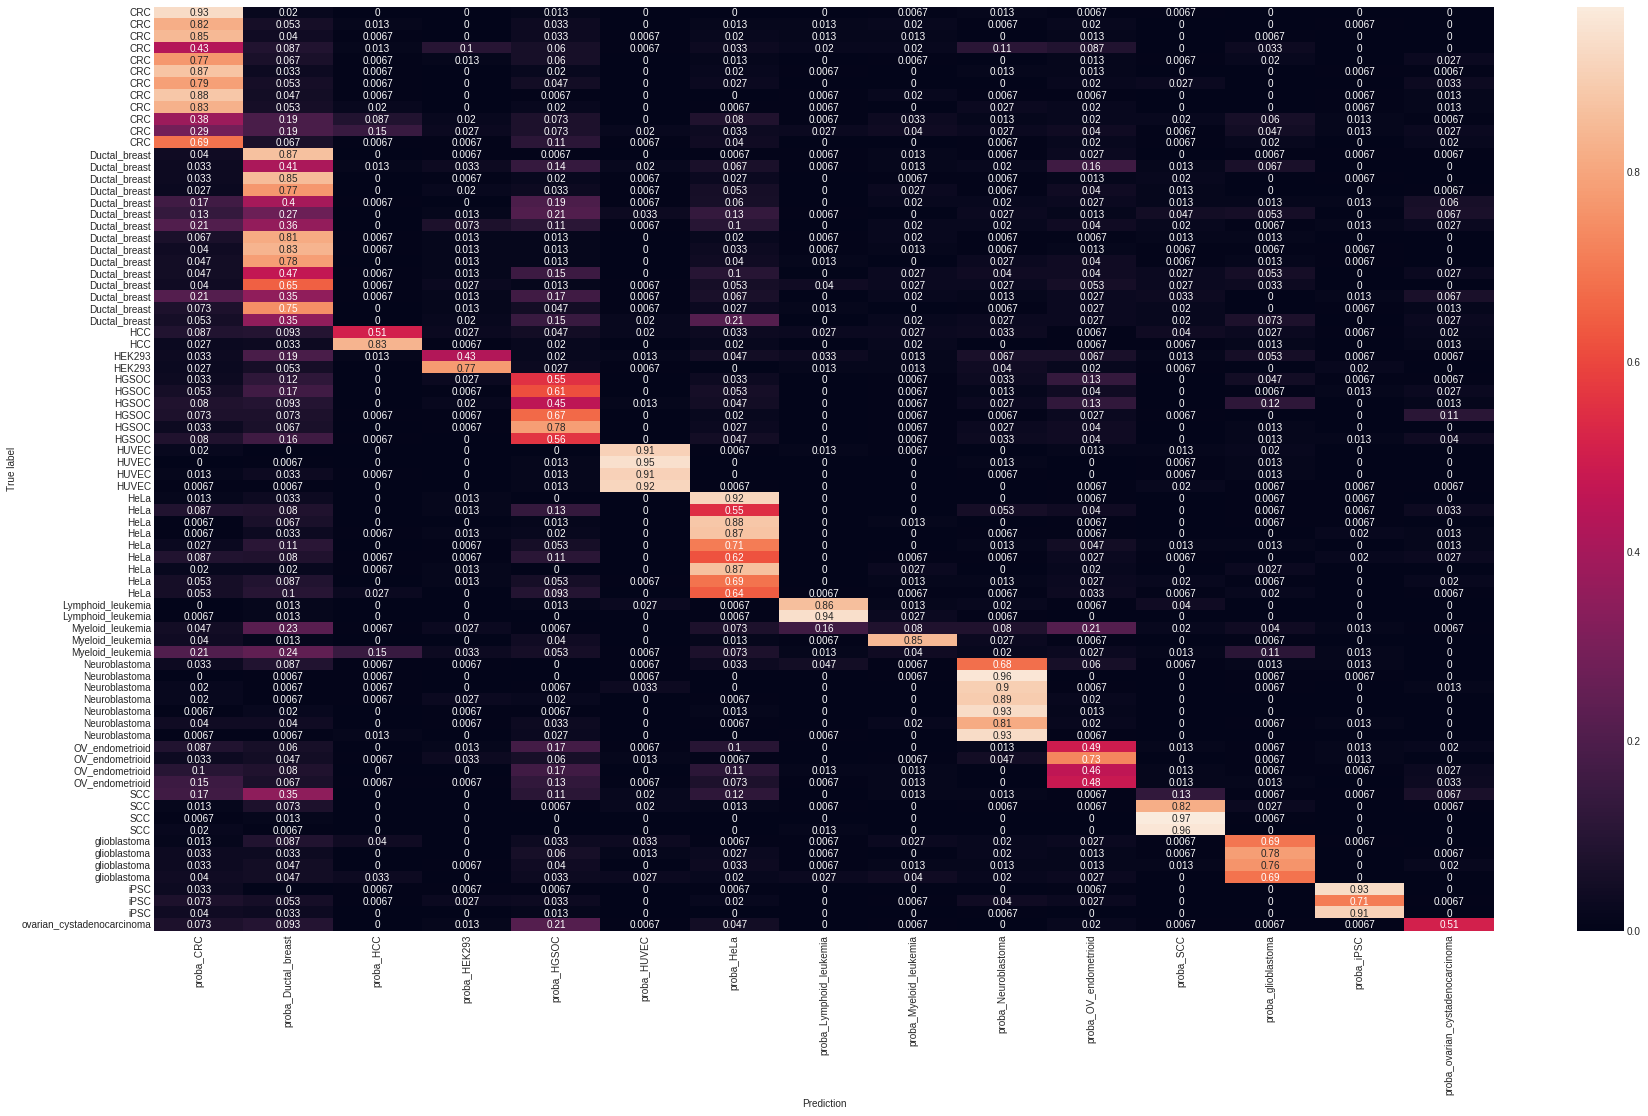

In [14]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_rf.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

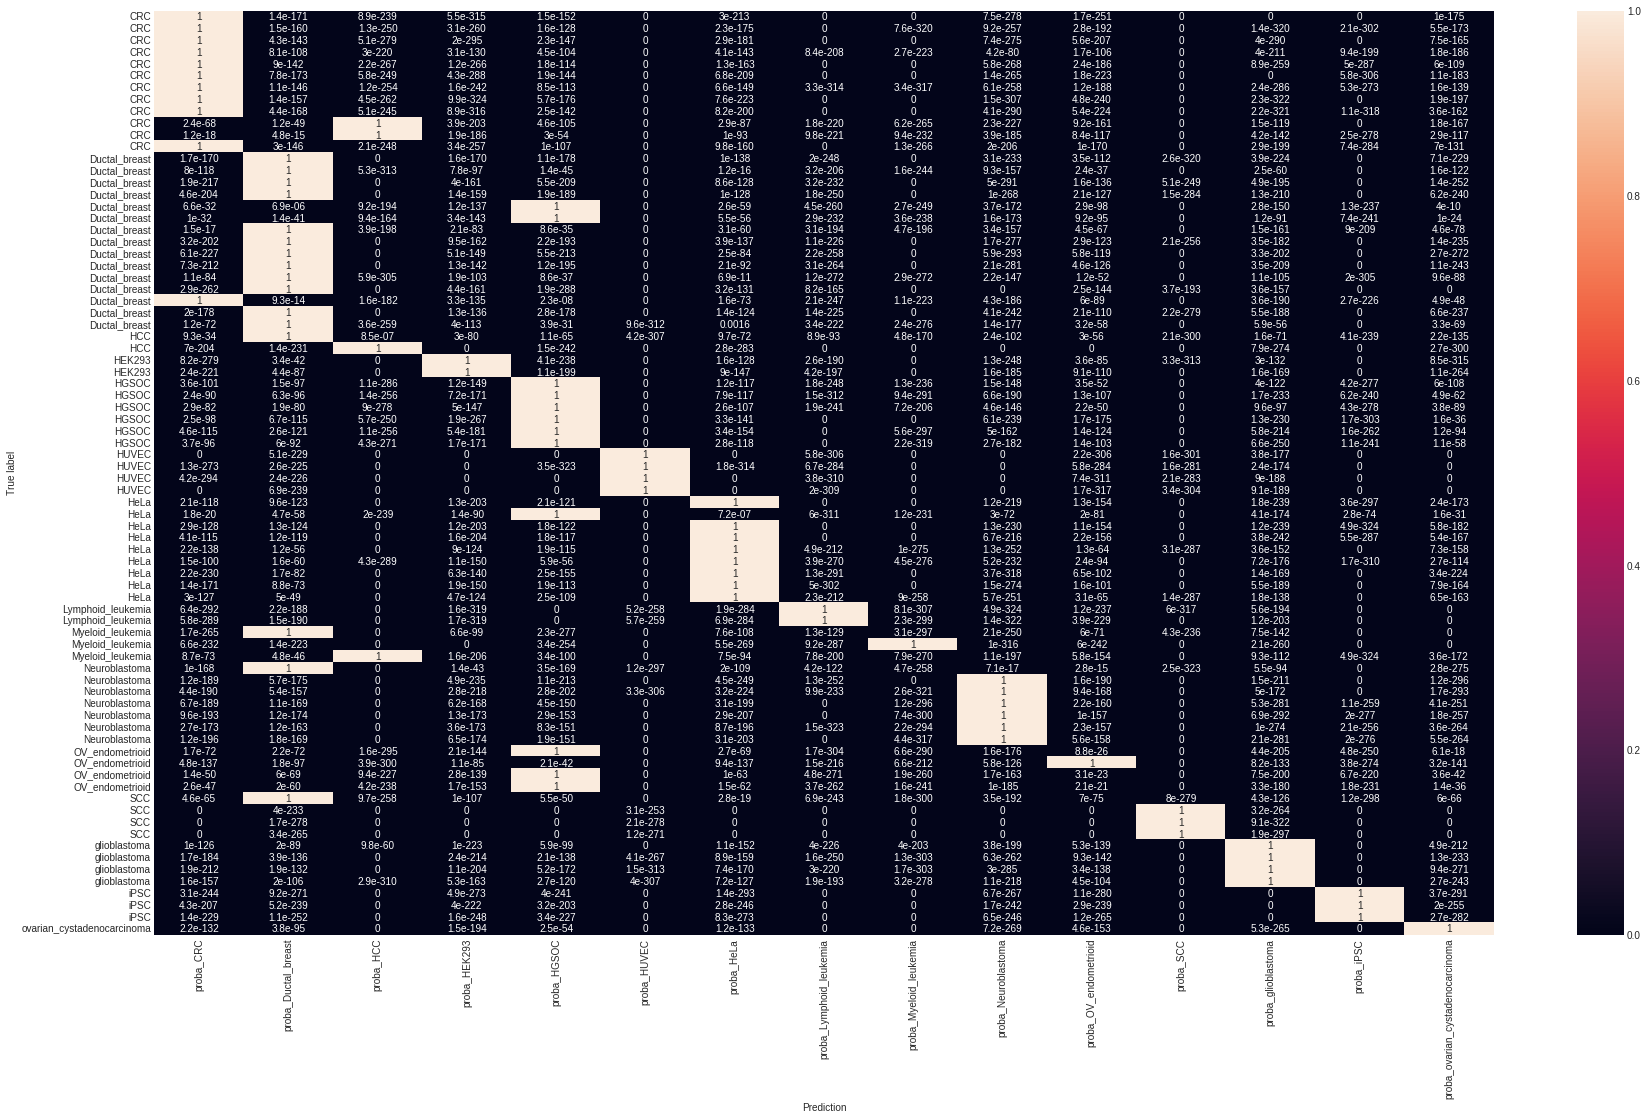

In [15]:
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_gnb.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

In [6]:
explainer_cpu_lr = shap.LinearExplainer(model_cpu_lr, X_train_oversampled_cpu)
shap_values_cpu_lr = explainer_cpu_lr.shap_values(X_test_processed_cpu)
shap_values_cpu_lr_train = explainer_cpu_lr.shap_values(X_train_processed_cpu)
print("LR explained")

explainer_cpu_svc = shap.LinearExplainer(model_cpu_svc, X_train_oversampled_cpu)
shap_values_cpu_svc = explainer_cpu_svc.shap_values(X_test_processed_cpu)
shap_values_cpu_svc_train = explainer_cpu_svc.shap_values(X_train_processed_cpu)
print("SVC explained")

explainer_cpu_rf = shap.TreeExplainer(model_cpu_rf)
shap_values_cpu_rf = explainer_cpu_rf.shap_values(X_test_processed_cpu)
shap_values_cpu_rf_train = explainer_cpu_rf.shap_values(X_train_processed_cpu)
print("RF explained")

LR explained
SVC explained
RF explained


In [10]:
target_encoder.inverse_transform(model_cpu_svc.classes_)

array(['CRC', 'Ductal_breast', 'HCC', 'HEK293', 'HGSOC', 'HUVEC', 'HeLa',
       'Lymphoid_leukemia', 'Myeloid_leukemia', 'Neuroblastoma',
       'OV_endometrioid', 'SCC', 'glioblastoma', 'iPSC',
       'ovarian_cystadenocarcinoma'], dtype=object)

In [ ]:
explainer_cpu_lr

In [17]:
file1 = open("./shap_values/cpu_lr_test", "wb")
file2 = open("./shap_values/cpu_svc_test", "wb")
file3 = open("./shap_values/cpu_rf_test", "wb")

file4 = open("./shap_values/cpu_lr_train", "wb")
file5 = open("./shap_values/cpu_svc_train", "wb")
file6 = open("./shap_values/cpu_rf_train", "wb")

np.save(file1, np.array(shap_values_cpu_lr))
np.save(file2, np.array(shap_values_cpu_svc))
np.save(file3, np.array(shap_values_cpu_rf))

np.save(file4, np.array(shap_values_cpu_lr_train))
np.save(file5, np.array(shap_values_cpu_svc_train))
np.save(file6, np.array(shap_values_cpu_rf_train))

file1.close
file2.close
file3.close
file4.close
file5.close
file6.close

<function BufferedWriter.close>

In [23]:
with open("./shap_values/cpu_features_uniprot.json", 'w') as feature_file:
    json.dump({"features": shap_features_cpu}, feature_file)

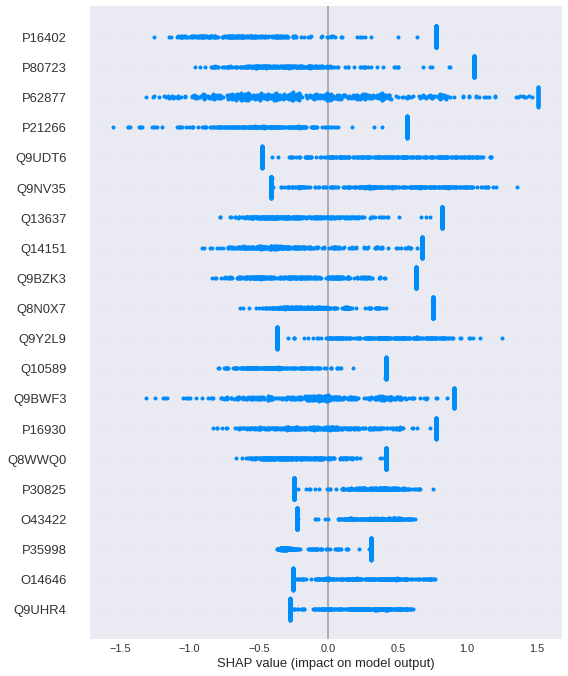

In [56]:
shap.summary_plot(shap_values_cpu_lr_train[0], feature_names = shap_features_cpu)

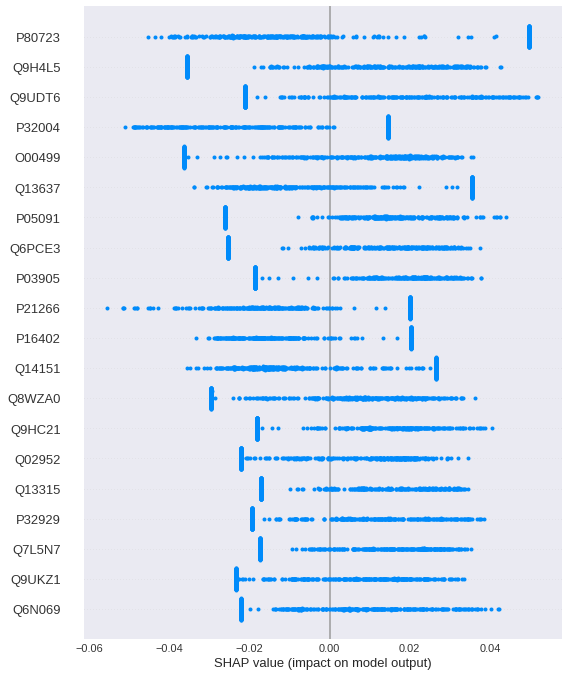

In [57]:
shap.summary_plot(shap_values_cpu_svc_train[0], feature_names = shap_features_cpu)

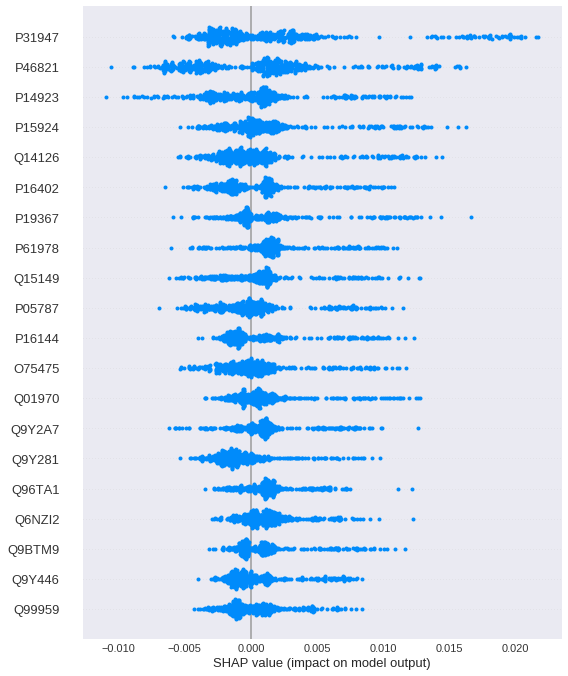

In [58]:
shap.summary_plot(shap_values_cpu_rf_train[0], feature_names = shap_features_cpu)

In [23]:
target_encoder.inverse_transform(model_bio_lr.classes_)

array(['CRC', 'Ductal_breast', 'HCC', 'HEK293', 'HGSOC', 'HUVEC', 'HeLa',
       'Lymphoid_leukemia', 'Myeloid_leukemia', 'Neuroblastoma',
       'OV_endometrioid', 'SCC', 'glioblastoma', 'iPSC',
       'ovarian_cystadenocarcinoma'], dtype=object)

In [70]:
y_train_df = pd.Series(y_train)

How is the size of the shap values distributed for each class. SHAP values show how much a single feature (protein) affects the prediction. Positive: for predicting that class; Negative: for not predicting that class

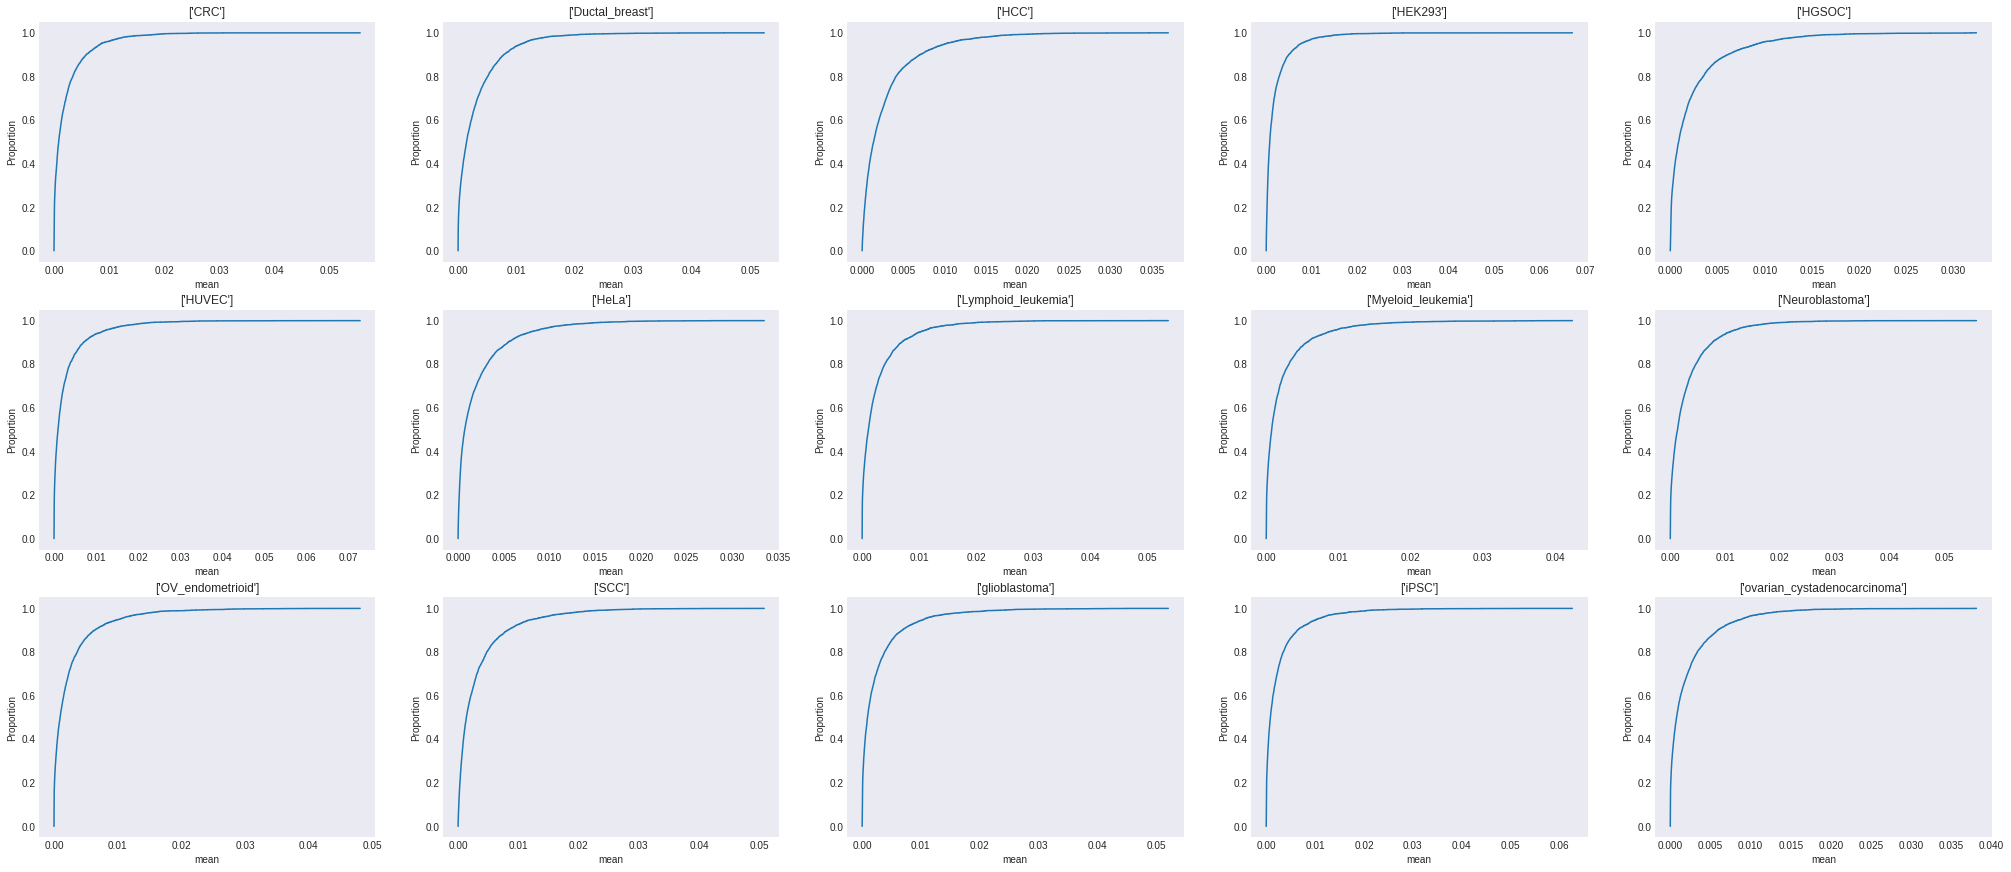

In [77]:
fig, ax = plt.subplots(3,5, figsize=(35,15))

y_axis = 0
x_axis = 0
for i in range(15):
    
    # Get the table of shap values for class i
    shaps_df = pd.DataFrame(shap_values_bio_lr_train[i], columns=shap_features_bio)

    # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train_df == i,:].mean(), columns = ["mean"])
    stat_shaps_df["std"] = shaps_df.loc[y_train_df == i,:].std()

    # Create cumulative distribution plot of the mean shap value of the proteins to see whether a few proteins have large shap value means for each class
    # This enables to inituitively select top % features based on their shap values
    ax[x_axis][y_axis].set_title(target_encoder.inverse_transform([i]))
    sns.ecdfplot(abs(stat_shaps_df['mean']), ax=ax[x_axis][y_axis])

    y_axis += 1
    if y_axis == 5:
        y_axis=0
        x_axis+=1

In [93]:
top_features = {}
for i in range(15):
    
    # Get the table of shap values for class i
    shaps_df = pd.DataFrame(shap_values_bio_lr_train[i], columns=shap_features_bio)

    # Create dataframe with mean of the shap values for the test_samples corresponding to the 
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train_df == i,:].mean(), columns = ["mean"])

    # Extract protein ids with > .01 shap
    top_proteins = stat_shaps_df[stat_shaps_df["mean"] > .01].index.tolist()
    top_features[target_encoder.inverse_transform([i])[0]] = top_proteins

What are these proteins for each class?

In [98]:
for label, proteins in top_features.items():
    print("{}: {}".format(label, len(proteins)))

with open("top_features_lr.json", "w") as f:
    f.write(json.dumps(top_features))

CRC: 182
Ductal_breast: 262
HCC: 247
HEK293: 136
HGSOC: 198
HUVEC: 285
HeLa: 150
Lymphoid_leukemia: 254
Myeloid_leukemia: 188
Neuroblastoma: 285
OV_endometrioid: 246
SCC: 347
glioblastoma: 257
iPSC: 256
ovarian_cystadenocarcinoma: 164


In [71]:
target_encoder.inverse_transform([7])

array(['Lymphoid_leukemia'], dtype=object)

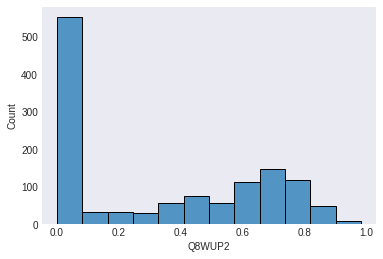

In [39]:
sns.histplot(pd.DataFrame(X_train_oversampled, columns = shap_features_bio).loc[:,"Q8WUP2"])

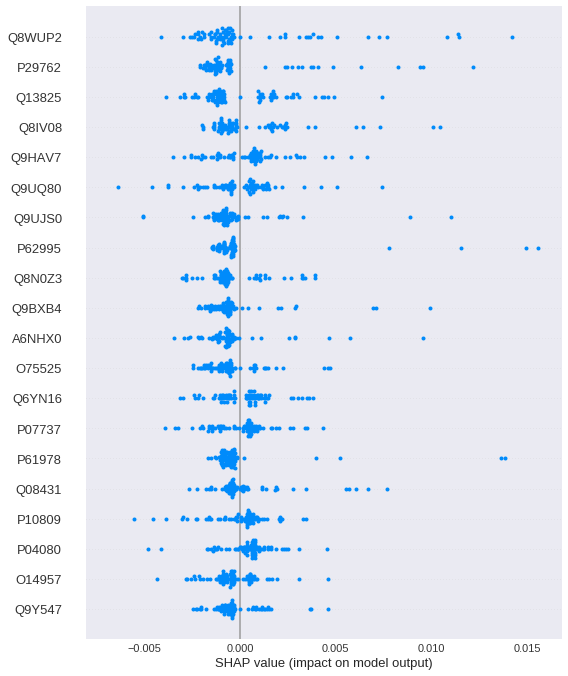

In [31]:
shap.summary_plot(shap_values_bio_rf[8], feature_names = shap_features_bio)

In [68]:
target_encoder.inverse_transform([9])

array(['Neuroblastoma'], dtype=object)

In [55]:
model_bio_rf.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [69]:
abs(pd.DataFrame(shap_values_bio_rf[9], columns = shap_features_bio).loc[:,:].mean()).sort_values()

P07237    0.000000
Q8IXB1    0.000000
O43175    0.000000
P51798    0.000000
Q9Y385    0.000000
            ...   
P49454    0.000534
Q9UPR3    0.000543
Q9Y478    0.000678
Q5VSL9    0.000736
Q9H9A6    0.000786
Length: 3999, dtype: float64

In [60]:
pd.DataFrame(shap_values_bio_rf[8], columns = shap_features_bio).loc[0,:][abs(pd.DataFrame(shap_values_bio_rf[8], columns = shap_features_bio).loc[:,:].mean())>.001]

Series([], Name: 0, dtype: float64)

In [149]:
train_targets[train_targets.Label_name == "SCC"].drop_duplicates()

Encoding Label_name
10        11        SCC

In [146]:
shap.Explanation(shap_obj_test[:,:,1], shap_obj_test.base_values[:,1], X_test_processed, feature_names=shap_feature_names)[2]

.values =
array([-0.00043824,  0.00305107,  0.00198204, ..., -0.00044705,
       -0.00317392,  0.00429982])

.base_values =
1.5758933890983549

.data =
array([0.38372185, 0.        , 0.80125976, ..., 0.        , 0.35316574,
       0.        ])

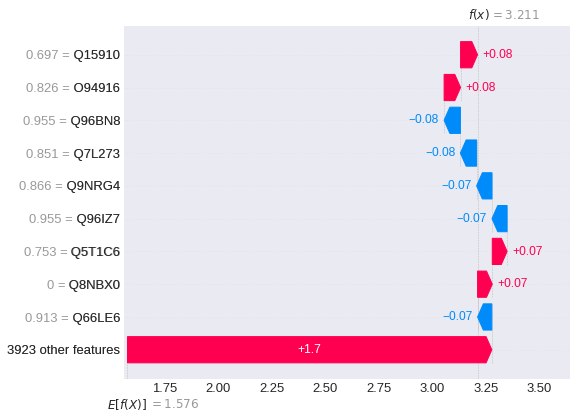

In [151]:
shap.waterfall_plot(shap_values= shap.Explanation(shap_obj_test[:,:,1], shap_obj_test.base_values[:,1], X_test_processed, feature_names=shap_feature_names)[2])

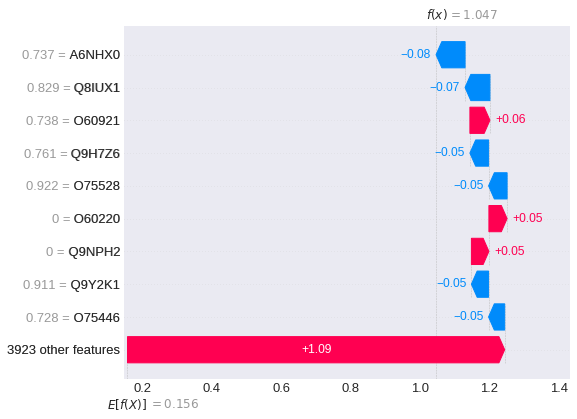

In [154]:
shap.waterfall_plot(shap_values= shap.Explanation(shap_obj_test[:,:,3], shap_obj_test.base_values[:,3], X_test_processed, feature_names=shap_feature_names)[2])

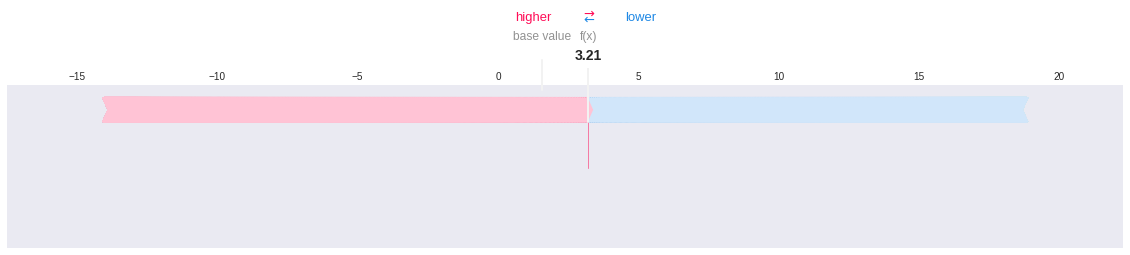

In [118]:
shap.force_plot(explainer.expected_value[1], shap_values_test[1][2], X_test_processed[2], feature_names = shap_feature_names, matplotlib=True)

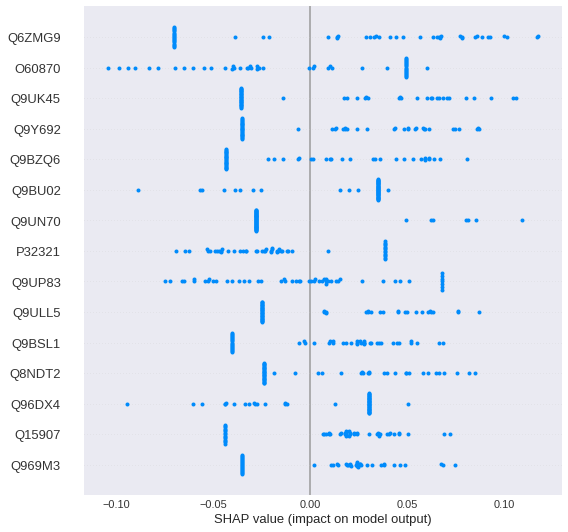

In [86]:
shap.summary_plot(shap_values_test[5], max_display=15, feature_names=shap_feature_names)

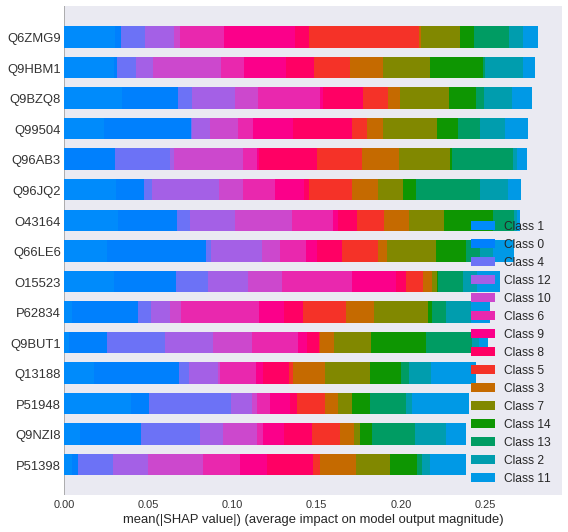

In [24]:
shap.summary_plot(shap_values_train, max_display=15, feature_names=shap_feature_names)

Plot importance per class

In [135]:
indices_neuro = train_targets[train_targets.Label_name == 'Neuroblastoma'].index
train_targets[train_targets.Label_name == 'Neuroblastoma'].head()

Encoding     Label_name
0          9  Neuroblastoma
6          9  Neuroblastoma
10         9  Neuroblastoma
41         9  Neuroblastoma
43         9  Neuroblastoma

In [64]:
shap_neuroblastoma = shap_values_train[9][indices_neuro]

In [90]:
len(shap_obj[0][0])

15